In [2]:
import gymnasium as gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Taxi-v3', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self,**kwargs):
        self.step_n = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)

        #一局游戏最多走N步
        self.step_n += 1
        if self.step_n >= 200:
            terminated = True

        return state, reward, terminated, truncated, info


env = MyWrapper()

env.reset()

(184, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

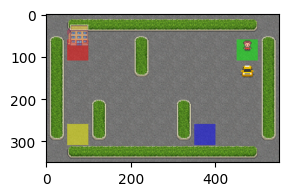

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.figure(figsize=(3, 3))
    plt.imshow(env.render())
    plt.show()


show()

In [4]:
#认识游戏环境
def test_env():
    print('env.observation_space=', env.observation_space)
    print('env.action_space=', env.action_space)

    state = env.reset()
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)

    print('state=', state)
    print('action=', action)
    print('next_state=', next_state)
    print('reward=', reward)
    print('done=', terminated)


test_env()

env.observation_space= Discrete(500)
env.action_space= Discrete(6)
state= (407, {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 0, 0], dtype=int8)})
action= 3
next_state= 407
reward= -1
done= False


In [5]:
import numpy as np

#定义Q矩阵,它评估了在每一个状态下,每一个动作的价值
Q = np.zeros([500, 6])

Q.shape

(500, 6)

In [25]:
import random


#获取action的函数,eps形容了随机性,取1时完全随机,取0时完全利用
def get_action(state, eps):
    if random.random() < eps:
        return env.action_space.sample()

    return Q[state].argmax()


get_action(0, 1) # 完全随机

1

In [42]:
from IPython import display


#测试一局游戏,得到reward_sum
def test(play=False):
    state,_ = env.reset()
    reward_sum = 0
    terminated = False

    while not terminated:
        action = get_action(state, 0)
        state, reward, terminated, truncated, info = env.step(action)
        reward_sum = reward + 0.95 * reward_sum

        if play:
            display.clear_output(wait=True)
            show()

    return reward_sum


np.mean([test() for _ in range(20)])

-19.999298946675015

In [43]:
#训练
def train():
    #等差数列,描述了动作的随机性,随机性随着训练进度,越来越倾向于利用
    eps = np.linspace(1, 0.01, 40000)

    #训练N局游戏
    for i in range(40000):
        state ,_ = env.reset()
        terminated= False

        #一局游戏
        while not  terminated:
            action = get_action(state, eps[i])
            next_state, reward, terminated, truncated, info = env.step(action)

            #计算QLearning的更新量
            #update = reward + 0.95 * next_state的最高分数 - 当前state,action的分数
            update = reward + 0.95 * Q[next_state].max() - Q[state][action]

            #更新Q矩阵,系数是lr
            Q[state][action] += 0.7 * update

            state = next_state

        if i % 2000 == 0:
            #测试N局游戏
            print(i, np.mean([test() for _ in range(5)]))

    np.savetxt('save/2.QLearning_Taxi', Q)


#train()

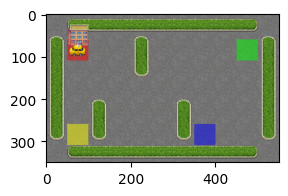

10.26582460319507

In [76]:
Q = np.loadtxt('save/2.QLearning_Taxi')

#试玩
test(play=True)